In [60]:
import pickle
import time
import random
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import json
import multiprocessing as mp
import os
from tqdm import tqdm
from pathlib import Path
from IPython.display import display
from shapely import LineString, Polygon, box
import torch
from pycocotools.coco import COCO

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['image.cmap'] = 'gist_rainbow'

In [3]:
# COCO_ANNOTATIONS_FILEPATH = "/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_12/intersect/coco-1024x750/train/annotations.json"
# COCO_ANNOTATIONS_FILEPATH = "/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_12/intersect/coco-1024x750/train/annotations.json"
COCO_ANNOTATIONS_FILEPATH = "/Users/geoffreygdelhomme/Documents/Datasets/coco-1024x750/train/annotations.json"
DEST_DIRPATH = "/mnt/data1/user_cache/geoffrey.g.delhomme/data/2023_12/intersect/preprocessed"
RUNWAY_HEADING_RANGE_DEG = 5
IMAGE_WIDTH = 1024
IMAGE_HEIGHT = 750
NUM_KEYPOINTS = 2

In [4]:
IMAGES_DIRPATH = Path(COCO_ANNOTATIONS_FILEPATH).parent / 'images'
ORIENTATIONS = [ # t: top, r: right, b: bottom, l: left
    "trbl", "rblt", "bltr", "ltrb"
]

In [5]:
global coco
coco = COCO(COCO_ANNOTATIONS_FILEPATH)

image_ids = coco.getImgIds()
print(f"{len(image_ids)} images")

loading annotations into memory...
Done (t=0.08s)
creating index...
index created!
6808 images


Keypoints order: bl, tl, tr, br, (cb, ct)

In [6]:
image_id = random.choice(image_ids)
sample_image = coco.loadImgs(image_id)[0]
display(sample_image)
sample_anns = coco.loadAnns(coco.getAnnIds(imgIds=image_id))
display(sample_anns)
# sample_image = random.choice(anns['images'])
# display(sample_image)
# sample_anns = [a for a in anns['annotations'] if a['image_id'] == sample_image['id']]
# display(sample_anns)

{'id': 1201,
 'file_name': 'sd0000001201.jpeg',
 'height': 750,
 'width': 1024,
 'date_captured': '2023/03/22 21:06:34',
 'source': '/mnt/data1/sim/datasets/aip/delivery_2023_q2/disjoint/v1.0/KONT_08L_A_2/images/000/0000074.jpeg'}

[{'image_id': 1201,
  'category_id': 1,
  'keypoints': [547.739990234375,
   369.7336730957031,
   2,
   485.7882995605469,
   326.35150146484375,
   2,
   498.81207275390625,
   326.6797180175781,
   2,
   573.4071655273438,
   370.3411865234375,
   2],
  'num_keypoints': 4,
  'segmentation': [[485.7882995605469,
    326.35150146484375,
    547.739990234375,
    369.7336730957031,
    573.4071655273438,
    370.3411865234375,
    498.81207275390625,
    326.6797180175781,
    485.7882995605469,
    326.35150146484375]],
  'bbox': [485.7882995605469,
   326.35150146484375,
   87.61886596679688,
   43.98968505859375],
  'area': 3854.326319070533,
  'iscrowd': 0,
  'id': 1682},
 {'image_id': 1201,
  'category_id': 1,
  'keypoints': [427.5075988769531,
   375.5906066894531,
   2,
   424.8755187988281,
   324.8143615722656,
   2,
   437.9444274902344,
   325.141357421875,
   2,
   456.1343688964844,
   376.2721862792969,
   2],
  'num_keypoints': 4,
  'segmentation': [[424.8755187988281,
 

----

# Playground

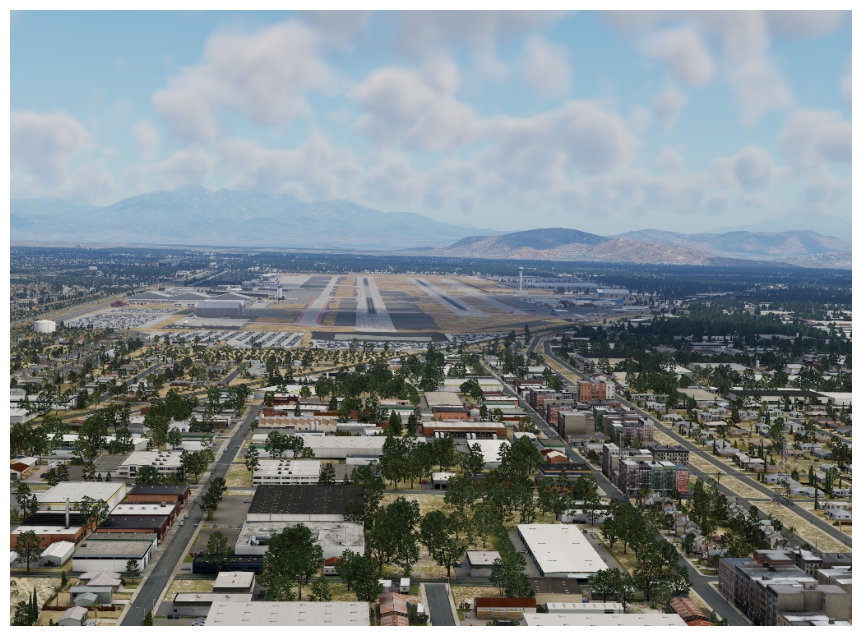

In [7]:
image_filepath = IMAGES_DIRPATH / sample_image['file_name']
im = cv2.imread(image_filepath.as_posix())
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
plt.axis('off');

In [8]:
sample = {
    'image_filepath': image_filepath.as_posix(),
    'targets': []
}
ann = sample_anns[0]
sample['targets'].append({})

(-0.5, 1023.5, 749.5, -0.5)

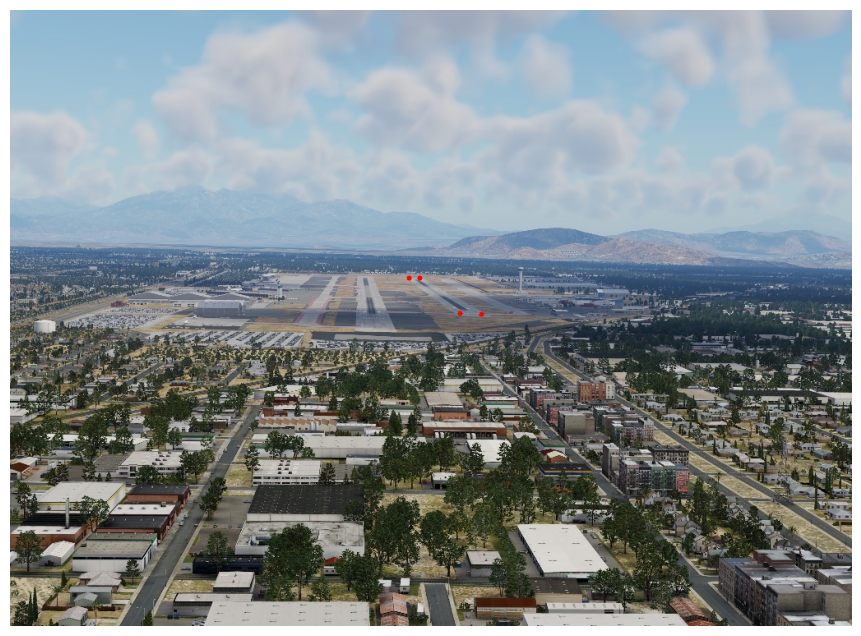

In [9]:
kpts = np.array(ann['keypoints']).reshape((-1, 3))
nkpts = kpts / [IMAGE_WIDTH, IMAGE_HEIGHT, 1]

sample['targets'][0]['kpts'] = kpts
sample['targets'][0]['nkpts'] = nkpts

im_draw = im.copy()
for kpt in sample['targets'][0]['kpts']:
    if kpt[2] == 2:
        cv2.circle(im_draw, (int(kpt[0]), int(kpt[1])), 3, (255, 0, 0), -1)

plt.figure()
plt.imshow(im_draw)
plt.axis('off')

3548

array([1024, 1774, 2798, 3548])

(2, 400)


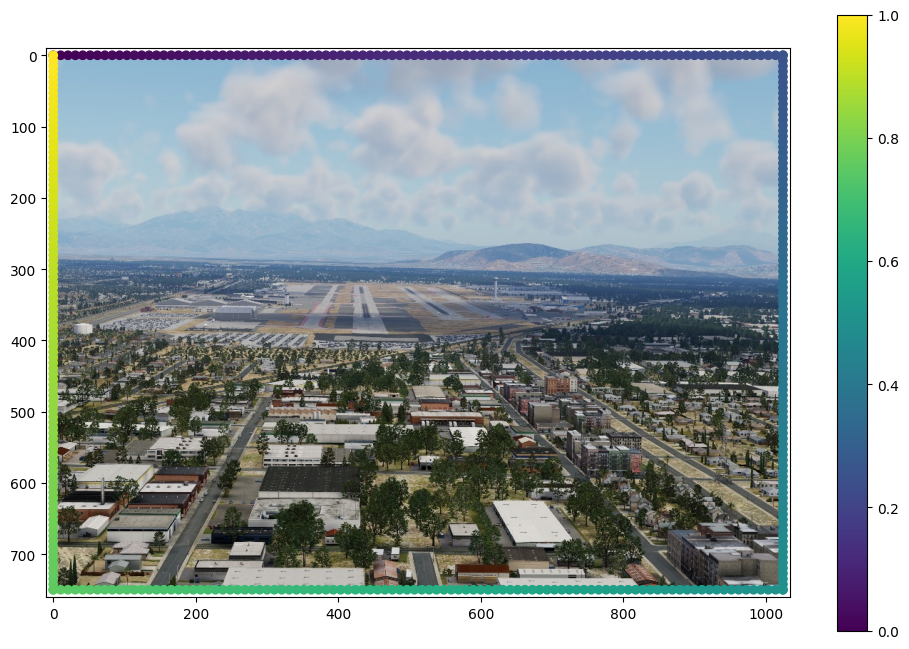

In [10]:
w, h = IMAGE_WIDTH, IMAGE_HEIGHT
perim = w * 2 + h * 2
display(perim)
perim_ticks = np.cumsum([w, h]*2)
display(perim_ticks)

x = np.linspace(0,1,100)
ptop = np.array([x*w, x*0])
pright = np.array([x*0+w, x*h])
pbottom = np.array([(w-x*w), x*0+h])
pleft = np.array([x*0, (h-x*h)])
p = np.concatenate((ptop, pright, pbottom, pleft), axis=1)
print(p.shape)

plt.figure()
plt.imshow(im)
plt.scatter(*p, c=np.linspace(0,1,4*len(x)))
plt.xlim(-10, w+10)
plt.ylim(h+10, -10)
plt.colorbar()

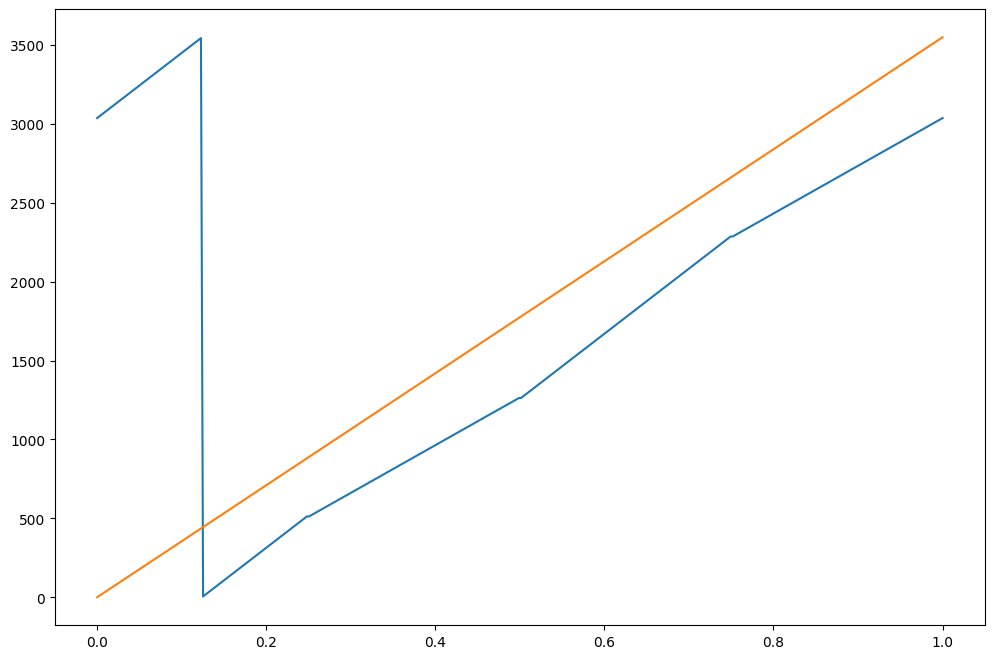

In [66]:
ORIENTATION = "trbl"*2

# def perim2border(x, y, borders):
#     z = 0.
#     for border in borders:
#         if border == 't':
#             if y == 0:
#                 z += x
#                 break
#             else:
#                 z += w
#         elif border == 'r':
#             if x == w:
#                 z += y
#                 break
#             else:
#                 z += h
#         elif border == 'b':
#             if y == h:
#                 z += (w - x)
#                 break
#             else:
#                 z += w
#         elif border == 'l':
#             if x == 0:
#                 z += (h - y)
#                 break
#             else:
#                 z += h
#     return z

def perim2border(x, y, borders):
    z = 0.
    borders += borders[0]
    imax = len(borders) - 1
    for i, border in enumerate(borders):
        if border == 't':
            if i == 0:
                if y == 0 and x >= w/2:
                    z += (x - w/2)
                    break
                else:
                    z += w/2
            elif i == imax:
                z += x
            else:
                if y == 0:
                    z += x
                    break
                else:
                    z += w
        elif border == 'r':
            if i == 0:
                if x == w and y >= h/2:
                    z += (y - h/2)
                    break
                else:
                    z += h/2
            elif i == imax:
                z += y
            else:
                if x == w:
                    z += y
                    break
                else:
                    z += h
        elif border == 'b':
            if i == 0:
                if y == h and (w - x) >= w/2:
                    z += (w - x) - w/2
                    break
                else:
                    z += w/2
            elif i == imax:
                z += (w - x)
            else:
                if y == h:
                    z += (w - x)
                    break
                else:
                    z += w
        elif border == 'l':
            if i == 0:
                if x == 0 and (h - y) >= h/2:
                    z += (h - y) - h/2
                    break
                else:
                    z += h/2
            elif i == imax:
                z += (h - y)
            else:
                if x == 0:
                    z += (h - y)
                    break
                else:
                    z += h
    return z



xx = np.linspace(0,1,p.shape[1])
zs = [perim2border(x,y,"trbl") for x,y in p.transpose((1,0))]

plt.figure()
plt.plot(xx, zs)
plt.plot(xx, xx*perim)

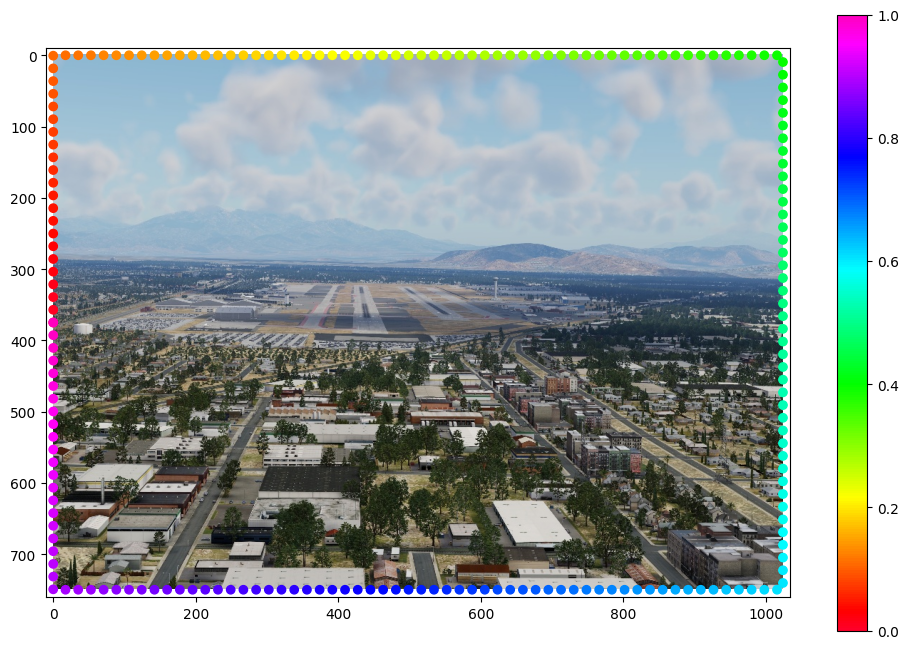

In [64]:
def border2perim(z, borders):
    if borders == "trbl":
        x = (
            torch.clip(z, 0, w) +
            torch.clip(w - (z - w - h), 0, w) - w
        )
        y = (
            torch.clip(z - w, 0, h) +
            torch.clip(h - (z - w - h - w), 0, h) - h
        )
    elif borders == "rblt":
        x = (
            w + torch.clip(w - (z - h), 0, w) + torch.clip(z - h - w - h, 0, w) - w
        )
        y = (
            torch.clip(z, 0, h) + torch.clip(h - (z - h - w), 0, h) - h
        )
    elif borders == "bltr":
        x = (
            w + torch.clip(w - z, 0, w) +
            torch.clip(z - h - w, 0, w) - w
        )
        y = (
            h + torch.clip(h - (z - w), 0, h) +
            torch.clip(z - w - h - w, 0, h) - h
        )
    elif borders == "ltrb":
        x = (
            torch.clip(z - h, 0, w) +
            torch.clip(w - (z - h - w - h), 0, w) - w
        )
        y = (
            h + torch.clip(h - z, 0, h) +
            torch.clip(z - w - h, 0, h) - h
        )
    return torch.stack((x, y))

def border2perim(z, borders):
    if borders == "trbl":
        x = (
            torch.clip(z, 0, w/2) + w/2 +
            torch.clip(w - (z - w/2 - h), 0, w) - w +
            torch.clip(z - w/2 - h - w - h, 0, w/2)
        )
        y = (
            torch.clip(z - w/2, 0, h) +
            torch.clip(h - (z - w/2 - h - w), 0, h) - h
        )
    elif borders == "rblt":
        x = (
            torch.clip(w - (z - h/2), 0, w) - w +
            torch.clip(z - h/2 - w - h, 0, w) + w
        )
        y = (
            torch.clip(z, 0, h/2) + h/2 +
            torch.clip(h - (z - h/2 - w), 0, h) - h +
            torch.clip(z - h/2 - w - h - w, 0, h/2)
        )
    elif borders == "bltr":
        x = (
            torch.clip(w/2 - z, 0, w/2) +
            torch.clip(z - w/2 - h, 0, w) +
            torch.clip(w/2 - (z - w/2 - h - w - h), 0, w/2) - w/2
        )
        y = (
            torch.clip(h - (z - w/2), 0, h) +
            torch.clip(z - w/2 - h - w, 0, h)
        )
    elif borders == "ltrb":
        x = (
            torch.clip(z - h/2, 0, w) +
            torch.clip(w - (z - h/2 - w - h), 0, w) - w
        )
        y = (
            torch.clip(h/2 - z, 0, h/2) +
            torch.clip(z - h/2 - w, 0, h) +
            torch.clip(h/2 - (z - h/2 - w - h - w), 0, h/2) - h/2
        )
    return torch.stack((x, y))

# p2 = border2perim(torch.from_numpy(np.array(zs)), 'trbl').numpy()

# plt.figure()
# plt.imshow(im)
# plt.scatter(*p2, c=np.linspace(0,1,4*len(x)))
# plt.xlim(-10, w+10)
# plt.ylim(h+10, -10)
# plt.colorbar()

p3 = border2perim(torch.linspace(0, perim, 200), 'ltrb').numpy()

plt.figure()
plt.imshow(im)
plt.scatter(*p3, c=np.linspace(0, 1, 200))
plt.xlim(-10, w+10)
plt.ylim(h+10, -10)
plt.colorbar()

0.18102469229598528


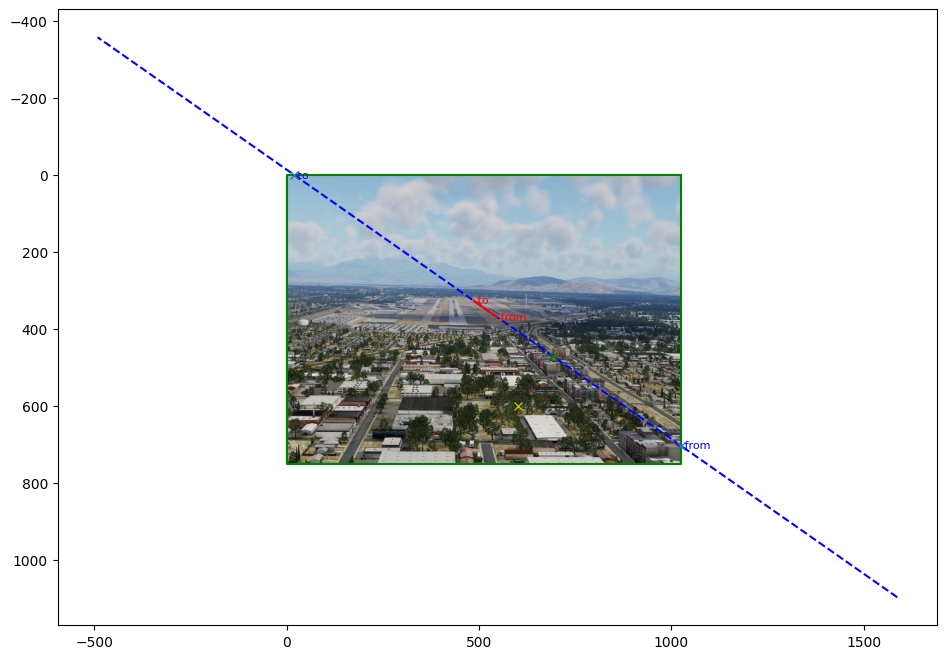

In [74]:
boundaries = (0, 0, IMAGE_WIDTH, IMAGE_HEIGHT)
envelope = box(*boundaries)
diag = np.linalg.norm(boundaries)
kpt_from, kpt_to = kpts[[0,1]]
segment = LineString((kpt_from, kpt_to))
diff = kpt_to - kpt_from
diff = diff / np.linalg.norm(diff) * diag
segment_extended = LineString((kpt_from - diff, kpt_from + diff))
inter = segment_extended.intersection(envelope)
xs, ys = zip(inter.xy)
kpt_ext_from, kpt_ext_to = [(x, y) for x, y in zip(*xs, *ys)]

plt.figure()
plt.imshow(im)
plt.plot(*envelope.exterior.xy, 'g')
plt.plot(*segment_extended.xy, 'b--')
plt.plot(*segment.xy, 'r')
plt.plot(*inter.xy, 'x')
plt.text(kpt_from[0], kpt_from[1], ' from', horizontalalignment='left', verticalalignment='center', fontsize=8, color='r')
plt.text(kpt_to[0], kpt_to[1], ' to', horizontalalignment='left', verticalalignment='center', fontsize=8, color='r')
plt.text(kpt_ext_from[0], kpt_ext_from[1], ' from', horizontalalignment='left', verticalalignment='center', fontsize=8, color='b')
plt.text(kpt_ext_to[0], kpt_ext_to[1], ' to', horizontalalignment='left', verticalalignment='center', fontsize=8, color='b')

kpt_test = np.array([600, 600])
kpt_ext_to = np.array(kpt_ext_to)
kpt_ext_from = np.array(kpt_ext_from)
l = np.sum((kpt_ext_to - kpt_ext_from) ** 2)
t = np.sum((kpt_test - kpt_ext_from)*(kpt_ext_to - kpt_ext_from)) / l
p = kpt_ext_from + t * (kpt_ext_to - kpt_ext_from)
print(np.linalg.norm(kpt_test-p)/np.sqrt(w*h))

plt.plot(600, 600, 'yx')
plt.plot(p[0], p[1], 'gx')

(0.0, 3548.0)

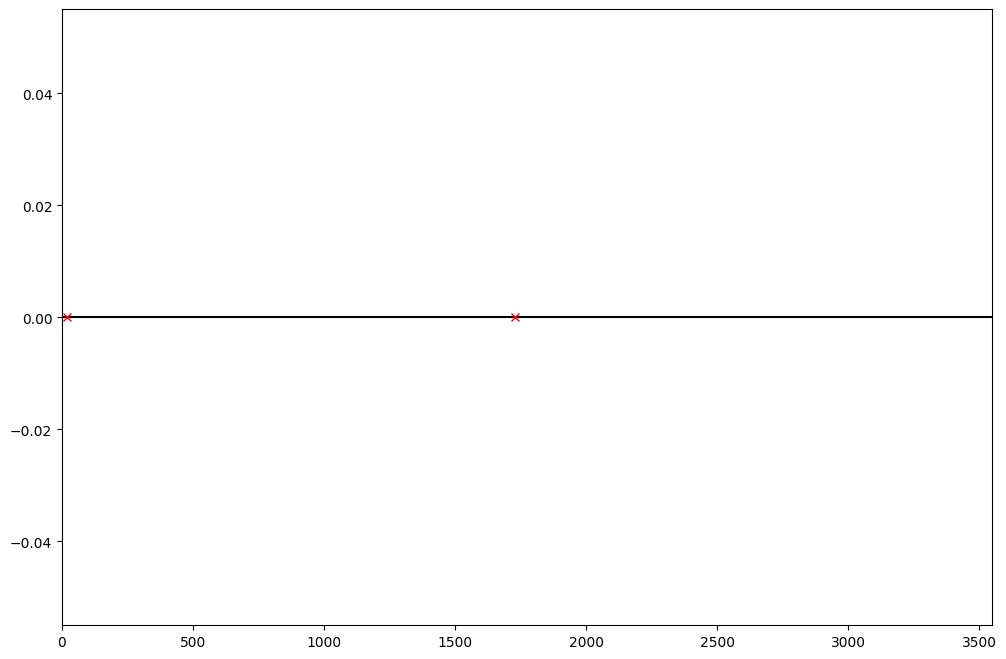

In [14]:
z_from = perim2border(kpt_ext_from[0], kpt_ext_from[1], 'trbl')
z_to = perim2border(kpt_ext_to[0], kpt_ext_to[1], 'trbl')

plt.figure()
plt.plot((0, perim), (0, 0), 'k')
plt.plot((z_from, z_to), (0, 0), 'rx')
plt.xlim(0, perim)

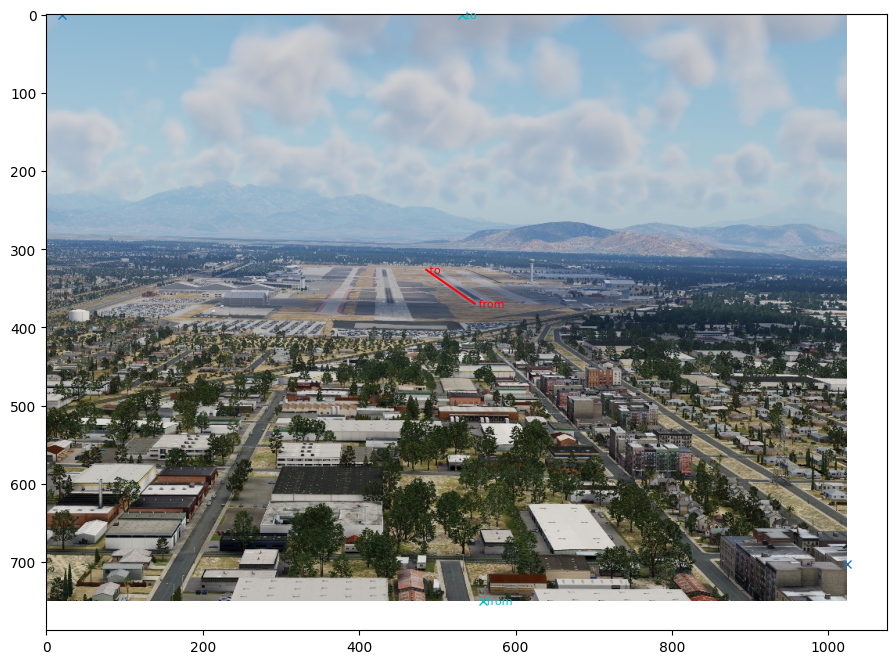

In [65]:
kpt_ext_from_2 = border2perim(torch.from_numpy(np.array(z_from)), 'trbl')
kpt_ext_to_2 = border2perim(torch.from_numpy(np.array(z_to)), 'trbl')

plt.figure()
plt.imshow(im)
# plt.plot(*envelope.exterior.xy, 'g')
# plt.plot(*segment_extended.xy, 'b--')
plt.plot(*segment.xy, 'r')
plt.plot(*inter.xy, 'x')
plt.text(kpt_from[0], kpt_from[1], ' from', horizontalalignment='left', verticalalignment='center', fontsize=8, color='r')
plt.text(kpt_to[0], kpt_to[1], ' to', horizontalalignment='left', verticalalignment='center', fontsize=8, color='r')
plt.text(kpt_ext_from_2[0], kpt_ext_from_2[1], ' from', horizontalalignment='left', verticalalignment='center', fontsize=8, color='c')
plt.text(kpt_ext_to_2[0], kpt_ext_to_2[1], ' to', horizontalalignment='left', verticalalignment='center', fontsize=8, color='c')
plt.plot((kpt_ext_from_2[0], kpt_ext_to_2[0]), (kpt_ext_from_2[1], kpt_ext_to_2[1]), 'cx')

___

# Dev

{'image': {'id': 1499440,
  'file_name': 'sd0001499440.jpeg',
  'height': 750,
  'width': 1024,
  'date_captured': '2023/03/22 06:06:35',
  'source': '/mnt/data1/sim/datasets/aip/delivery_2023_q2/disjoint/v1.0/VTSM_35_A_2/images/000/0000052.jpeg'},
 'annotations': [{'image_id': 1499440,
   'category_id': 1,
   'keypoints': [467.1494140625,
    383.19366455078125,
    2,
    478.3367919921875,
    331.5644226074219,
    2,
    497.1688537597656,
    340.5709228515625,
    2,
    499.1419677734375,
    398.8434143066406,
    2],
   'num_keypoints': 4,
   'segmentation': [[478.3367919921875,
     331.5644226074219,
     467.1494140625,
     383.19366455078125,
     499.1419677734375,
     398.8434143066406,
     497.1688537597656,
     340.5709228515625,
     478.3367919921875,
     331.5644226074219]],
   'bbox': [467.1494140625,
    331.5644226074219,
    31.9925537109375,
    67.27899169921875],
   'area': 2152.426755554974,
   'iscrowd': 0,
   'id': 1991212,
   'intersect': {'left': {

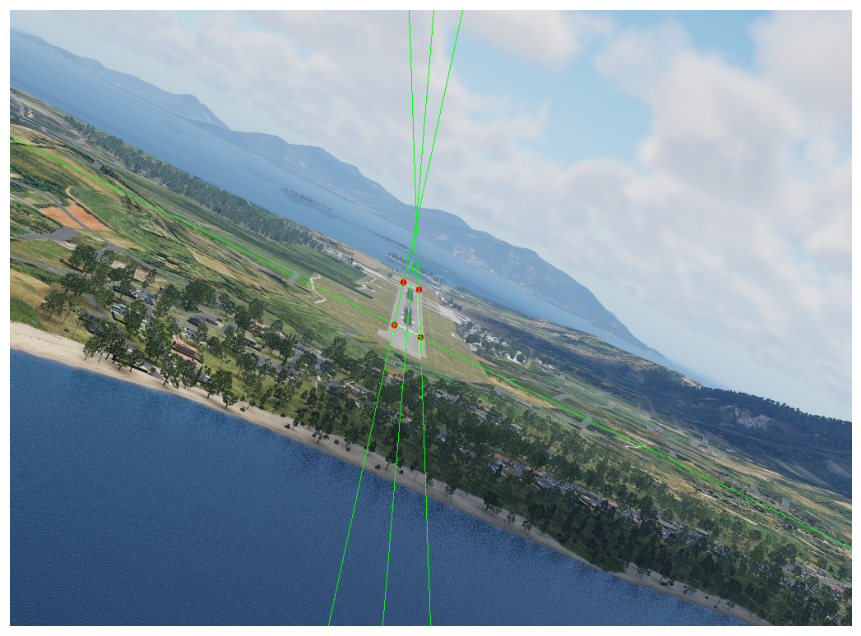

In [21]:
def image2bound(x, y, w, h, boundaries):
    z = 0.
    for boundary in boundaries:
        if boundary == 't':
            if y == 0:
                z += x
                break
            else:
                z += w
        elif boundary == 'r':
            if x == w:
                z += y
                break
            else:
                z += h
        elif boundary == 'b':
            if y == h:
                z += (w - x)
                break
            else:
                z += w
        elif boundary == 'l':
            if x == 0:
                z += (h - y)
                break
            else:
                z += h
    return z

def bound2image(z, w, h, boundaries):
    if boundaries == "trbl":
        x = (
            torch.clip(z, 0, w) +
            torch.clip(w - (z - w - h), 0, w) - w
        )
        y = (
            torch.clip(z - w, 0, h) +
            torch.clip(h - (z - w - h - w), 0, h) - h
        )
    elif boundaries == "rblt":
        x = (
            w + torch.clip(w - (z - h), 0, w) + torch.clip(z - h - w - h, 0, w) - w
        )
        y = (
            torch.clip(z, 0, h) + torch.clip(h - (z - h - w), 0, h) - h
        )
    elif boundaries == "bltr":
        x = (
            w + torch.clip(w - z, 0, w) +
            torch.clip(z - h - w, 0, w) - w
        )
        y = (
            h + torch.clip(h - (z - w), 0, h) +
            torch.clip(z - w - h - w, 0, h) - h
        )
    elif boundaries == "ltrb":
        x = (
            torch.clip(z - h, 0, w) +
            torch.clip(w - (z - h - w - h), 0, w) - w
        )
        y = (
            h + torch.clip(h - z, 0, h) +
            torch.clip(z - w - h, 0, h) - h
        )
    return torch.stack((x, y))

def worker_init():
    global coco
    coco = COCO(COCO_ANNOTATIONS_FILEPATH)

def process(image_id):
    global coco
    sample_image = coco.loadImgs(image_id)[0]
    sample_anns = coco.loadAnns(coco.getAnnIds(imgIds=image_id))
    sample = {
        'image': sample_image,
        'annotations': []
    }
    w, h = (sample_image[k] for k in ['width', 'height'])
    perim = w*2 + h*2
    valid = False
    for sample_ann in sample_anns:
        ann = sample_ann
        kpts = np.array(ann['keypoints']).reshape((4, 3)) # bl, tl, tr, br
        edge_left, edge_right, edge_bottom = kpts[[0, 1]], kpts[[3, 2]], kpts[[0, 3]]
        edge_center = (edge_left + edge_right) / 2.
        bounds = (0, 0, w, h)
        enveloppe = box(*bounds)
        diag = np.linalg.norm(bounds)
        ann['intersect'] = {}
        for name, edge in zip(('left', 'right', 'bottom', 'center'), [edge_left, edge_right, edge_bottom, edge_center]):
            edge, validity = edge[:, :2], edge[:, 2]
            if not validity[0] or not validity[1]:
                ann['intersect'][name] = None
                continue
            intersect = {}
            segement = LineString(edge)
            diff = edge[1] - edge[0]
            diff = diff / np.linalg.norm(diff) * diag
            segment_extended = LineString((edge[0] - diff, edge[0] + diff))
            intersection = segment_extended.intersection(enveloppe)
            intersect['kpts'] = list(zip(*intersection.xy))
            intersect['zs'] = {o: [image2bound(kpt[0], kpt[1], w, h, o) for kpt in intersect['kpts']] for o in ORIENTATIONS}
            ann['intersect'][name] = intersect
            valid = True
        sample['annotations'].append(ann)
    return sample if valid else None

def draw_targets(sample):
    image_filepath = IMAGES_DIRPATH / sample['image']['file_name']
    im = cv2.imread(image_filepath.as_posix())
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    w, h = sample['image']['width'], sample['image']['height']
    for ann in sample['annotations']:
        kpts = np.array(ann['keypoints']).reshape((4,3))
        for kpt in kpts:
            if kpt[2] == 2:
                cv2.circle(im, (int(kpt[0]), int(kpt[1])), 4, (255, 0, 0), -1)
        for name, intersect in ann['intersect'].items():
            if intersect is not None:
                # kpts = intersect['kpts']
                # cv2.line(im, (int(kpts[0][0]), int(kpts[0][1])), (int(kpts[1][0]), int(kpts[1][1])), (255, 0, 0), 1)
                zs = intersect['zs']
                for o in ORIENTATIONS:
                    kpts2 = [bound2image(torch.tensor(z), w, h, o).numpy().tolist() for z in zs[o]]
                    cv2.line(im, (int(kpts2[0][0]), int(kpts2[0][1])), (int(kpts2[1][0]), int(kpts2[1][1])), (0, 255, 0), 1)

    plt.figure()
    plt.imshow(im)
    plt.axis('off')


# sample = process(random.choice(image_ids))
sample = process(1499440)
display(sample)

draw_targets(sample) if sample else None


In [19]:
dataset = []
with mp.Pool(10, initializer=worker_init) as pool:
    for sample in pool.imap_unordered(process, tqdm(image_ids)):
        if sample:
            dataset.append(sample)
print(f"Dataset length: {len(dataset)}")
# save
save_filepath = Path(DEST_DIRPATH) / (Path(COCO_ANNOTATIONS_FILEPATH).parent.name + '.p')
save_filepath.parent.mkdir(parents=True, exist_ok=True)
with open(save_filepath.as_posix(), 'wb') as f:
    pickle.dump(dataset, f)

loading annotations into memory...
loading annotations into memory...
loading annotations into memory...loading annotations into memory...

loading annotations into memory...loading annotations into memory...

loading annotations into memory...
loading annotations into memory...
loading annotations into memory...
loading annotations into memory...

  0%|          | 0/2147495 [00:00<?, ?it/s]

Done (t=50.02s)
creating index...
index created!
Done (t=54.11s)
creating index...
Done (t=54.10s)
creating index...
Done (t=54.51s)
creating index...
Done (t=54.98s)
creating index...
Done (t=55.40s)
creating index...
Done (t=55.90s)
creating index...
Done (t=55.21s)
creating index...
Done (t=55.58s)
creating index...
Done (t=55.59s)
creating index...
index created!
index created!
index created!
index created!
index created!
index created!


  0%|          | 1211/2147495 [00:58<28:40:30, 20.79it/s]

index created!


  0%|          | 1886/2147495 [00:58<13:16:08, 44.92it/s]

index created!


  0%|          | 3236/2147495 [00:59<2:52:37, 207.03it/s]

index created!


100%|██████████| 2147495/2147495 [06:33<00:00, 5453.55it/s] 


Dataset length: 1751314
